# Import Library

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.8 MB/s eta 0:00:00


In [2]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Library Statistik untuk EDA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [3]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

Mounted at /content/drive


In [4]:
# Load Dataset
transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))

## Merging Data

In [5]:
# 2. Merging Lengkap (Identik dengan notebook sebelumnya)
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [6]:
# 3. Filter Toko Rumah Tangga (Store ID 5)
TARGET_STORE_ID = 3
df_home = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_home['transactionDate'] = pd.to_datetime(df_home['transactionDate'])

## Data Cleaning

In [7]:
# 4. Agregasi Harian
time_series_home = df_home.groupby(df_home['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_home.columns = ['date', 'revenue']
time_series_home['date'] = pd.to_datetime(time_series_home['date'])
time_series_home.set_index('date', inplace=True)

In [8]:
# 5. Reindex Tanggal agar berurutan (Mencegah gap hari)
all_days = pd.date_range(start=time_series_home.index.min(), end=time_series_home.index.max(), freq='D')
time_series_home = time_series_home.reindex(all_days, fill_value=0)

In [9]:
# 6. Outlier Handling (Clipping)
Q1, Q3 = time_series_home['revenue'].quantile([0.25, 0.75])
IQR = Q3 - Q1
time_series_home['revenue_clean'] = time_series_home['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Household (Store {TARGET_STORE_ID}) siap.")

Data Household (Store 3) siap.


# Exploratory Data Analysis (EDA)

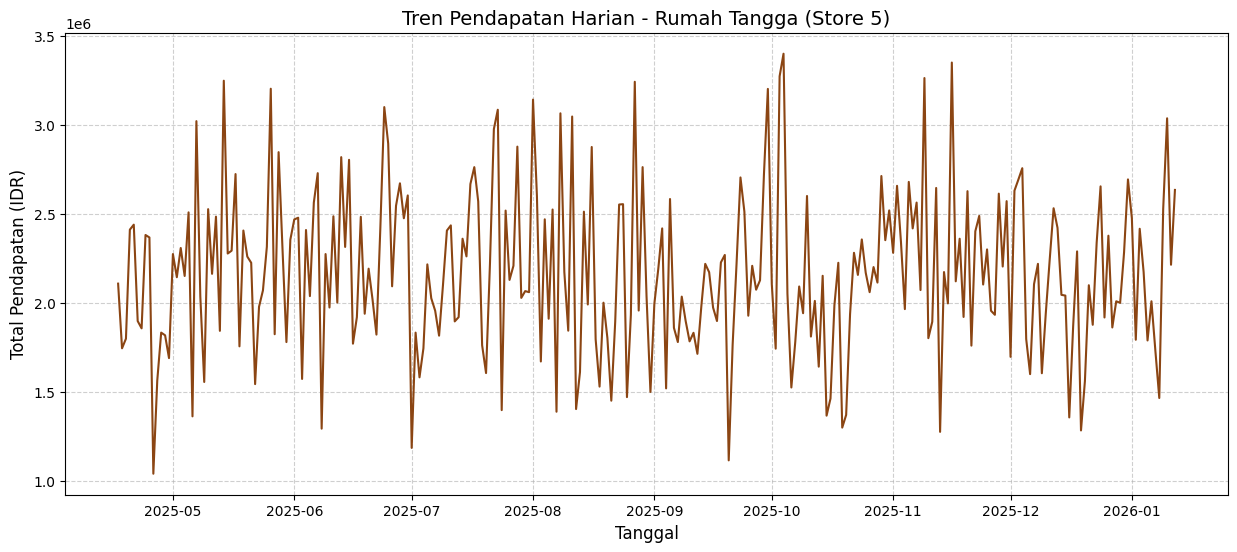

In [10]:
# 1. Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_home.index, time_series_home['revenue_clean'], color='saddlebrown', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Rumah Tangga (Store 5)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

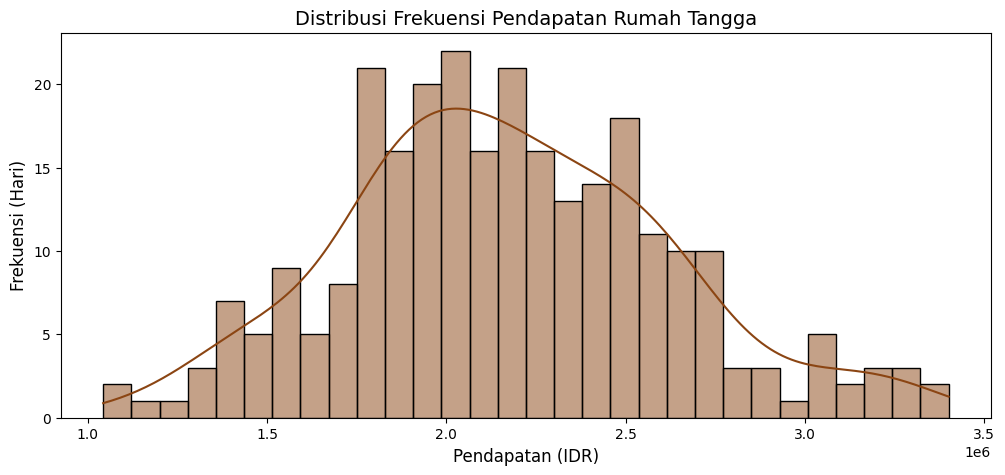

In [11]:
# 2. Distribusi Pendapatan (Histogram & KDE)
plt.figure(figsize=(12, 5))
sns.histplot(time_series_home['revenue_clean'], kde=True, color='saddlebrown', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Rumah Tangga', fontsize=14)
plt.xlabel('Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi (Hari)', fontsize=12)
plt.show()

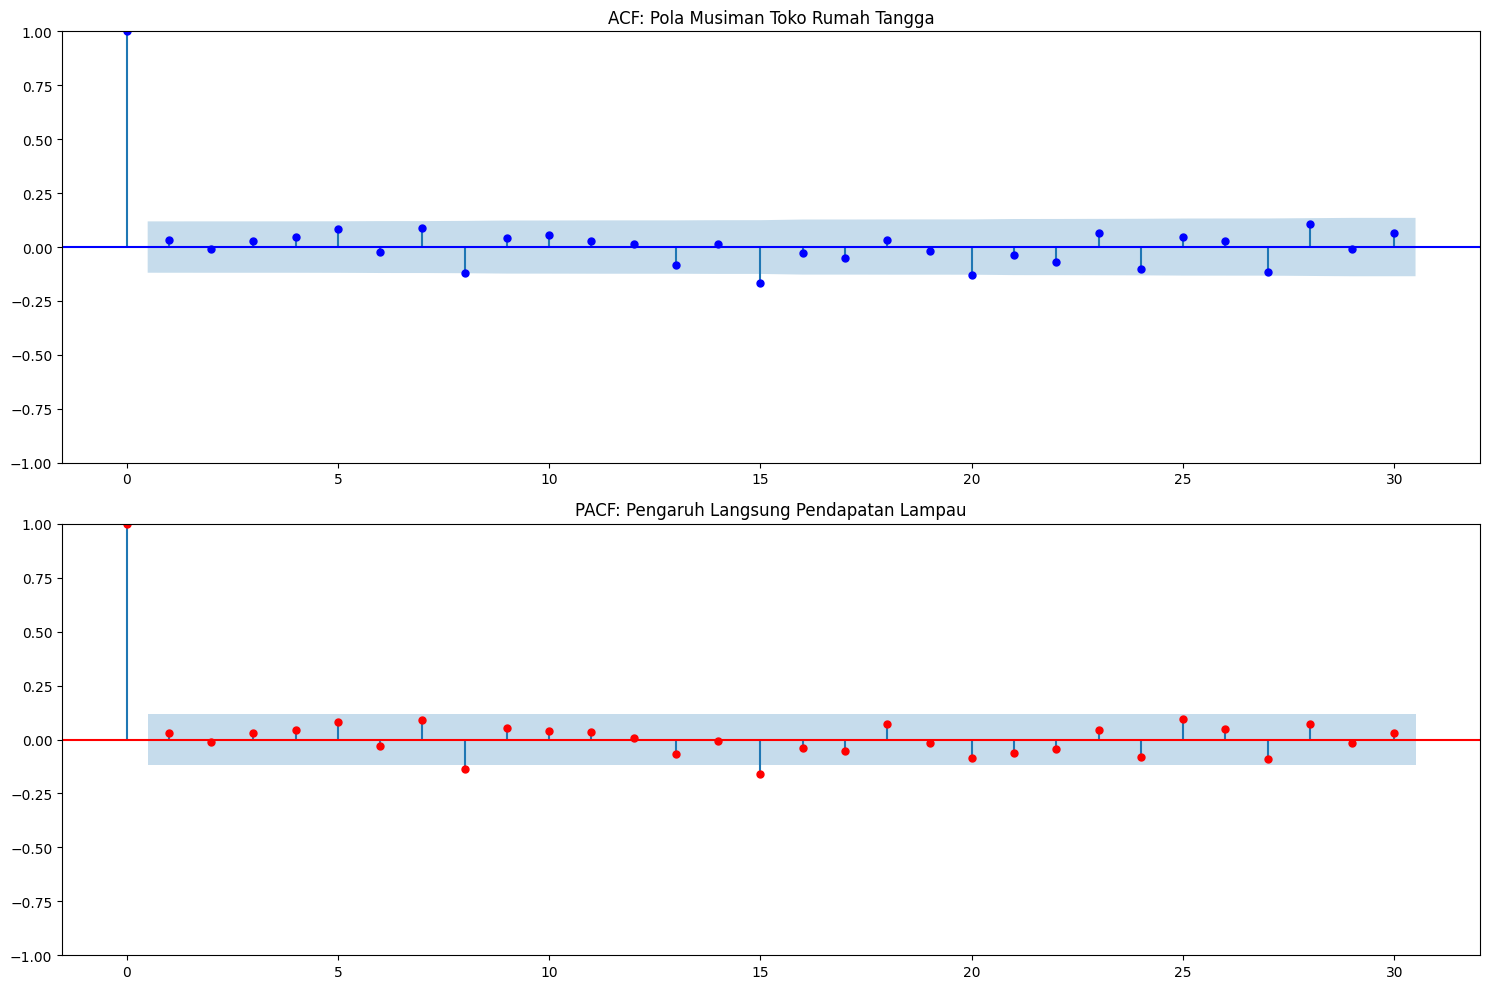

In [12]:
# 3. Autocorrelation (ACF) & Partial Autocorrelation (PACF)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(time_series_home['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Pola Musiman Toko Rumah Tangga', fontsize=12)
plot_pacf(time_series_home['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1607188085.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='revenue_clean', data=time_series_home, order=order, palette='YlOrBr')


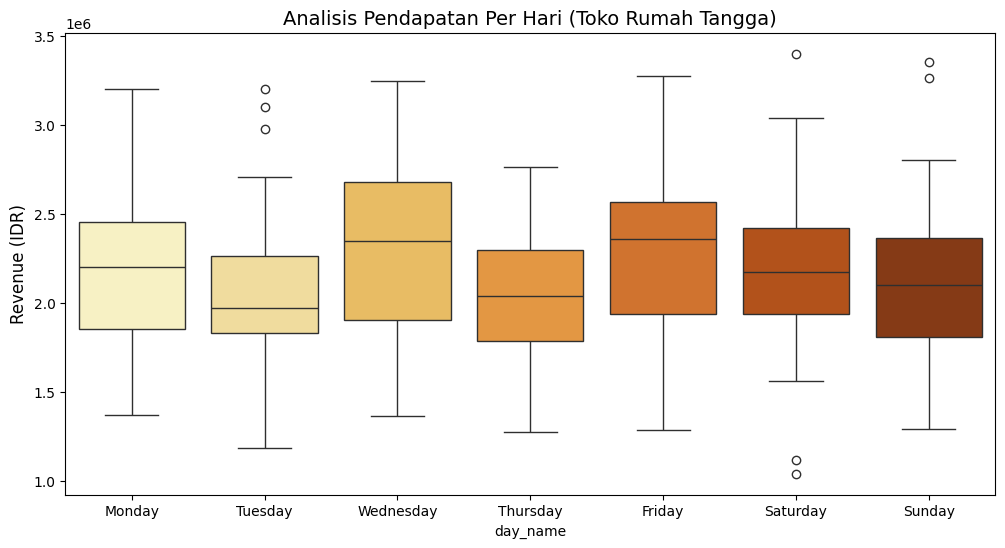

In [13]:
# 4. Boxplot Hari dalam Seminggu (Analisis Peak Time)
time_series_home['day_name'] = time_series_home.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_home, order=order, palette='YlOrBr')
plt.title('Analisis Pendapatan Per Hari (Toko Rumah Tangga)', fontsize=14)
plt.ylabel('Revenue (IDR)', fontsize=12)
plt.show()

In [14]:
# 5. Ringkasan Statistik Lengkap
stats = time_series_home['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK RUMAH TANGGA (STORE 5)")
print("="*45)
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Maksimum            : Rp {stats['max']:,.2f}")
print(f"Minimum             : Rp {stats['min']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK RUMAH TANGGA (STORE 5)
Rata-rata Harian    : Rp 2,166,902.21
Standar Deviasi     : Rp 452,960.45
Median (P50)        : Rp 2,131,000.00
Maksimum            : Rp 3,400,500.00
Minimum             : Rp 1,043,000.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [15]:
# 1. Feature Engineering
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_home['is_holiday'] = time_series_home.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)
time_series_home['is_payday'] = time_series_home.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)
time_series_home['is_weekend'] = time_series_home.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [16]:
# Tambahkan Fitur Lag (1-7 hari sebelumnya)
for i in range(1, 8):
    time_series_home[f'lag_{i}'] = time_series_home['revenue_clean'].shift(i)

In [17]:
# Tambahkan Tren (Rolling Mean 7 hari)
time_series_home['rolling_avg_7d'] = time_series_home['revenue_clean'].rolling(window=7).mean()

In [18]:
# Update Feature Engineering (Menambah Day of Month)
time_series_home['day_of_month'] = time_series_home.index.day

In [19]:
# Hapus baris yang kosong akibat proses Lag
time_series_home.dropna(inplace=True)

## Scaling

In [20]:
# 2. Pemisahan Fitur (X) dan Target (y)
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_home[features]
y_raw = time_series_home['revenue_clean']

In [21]:
# 3. Scaling (Mengubah angka jutaan ke skala 0-1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [22]:
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [23]:
# 4. Reshaping ke format 3D untuk LSTM [Samples, Time Steps, Features]
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

## Splitting Data (Train & Test)

In [24]:
# 5. Split Data (80% Training, 20% Testing)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Preprocessing Selesai! Data siap dilatih dengan {X_train.shape[2]} fitur.")

Preprocessing Selesai! Data siap dilatih dengan 12 fitur.


# Modeling

In [25]:
def model_builder(hp):
    model = Sequential()

    # 1. CNN Layer (Mencari pola fitur penting)
    model.add(Conv1D(
        filters=hp.Int("conv_filters", 32, 128, 16),
        kernel_size=1, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # 2. Bidirectional LSTM (Mempelajari pola masa lalu secara bolak-balik)
    model.add(Bidirectional(LSTM(units=hp.Int("bilstm_units", 64, 256, 32), return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.4, 0.1)))

    # 3. LSTM Layer Kedua
    model.add(LSTM(units=hp.Int("lstm_units", 32, 128, 32), return_sequences=False))

    # 4. Output Layer
    model.add(Dense(hp.Int("dense_units", 32, 128, 32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Hapus folder tuning lama agar tidak konflik
tuner_path = 'tuner_dir/home_final_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)

# Mulai pencarian model terbaik
tuner = kt.RandomSearch(
    model_builder, objective='val_loss', max_trials=10,
    directory='tuner_dir', project_name='home_final_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Sedang mencari model terbaik (Hyperparameter Tuning)...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Ambil model terbaik hasil tuning
best_model = tuner.get_best_models(num_models=1)[0]
print("\nArsitektur Model Terbaik Berhasil Dibuat!")
best_model.summary()

Trial 10 Complete [00h 00m 20s]
val_loss: 0.016888350248336792

Best val_loss So Far: 0.007030725013464689
Total elapsed time: 00h 03m 20s

Arsitektur Model Terbaik Berhasil Dibuat!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 96)          │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       230,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,049 (1.21 MB)

 Trainable params: 318,049 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [26]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model akhir...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model akhir...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0224 - mae: 0.1162 - val_loss: 0.0170 - val_mae: 0.1083
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0129 - mae: 0.0977 - val_loss: 0.0088 - val_mae: 0.0678
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0078 - mae: 0.0688 - val_loss: 0.0112 - val_mae: 0.0870
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0076 - mae: 0.0691 - val_loss: 0.0077 - val_mae: 0.0701
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061 - mae: 0.0604 - val_loss: 0.0060 - val_mae: 0.0597
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - mae: 0.0498 - val_loss: 0.0054 - val_mae: 0.0545
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042 - mae: 0.0526 - val_loss: 0.0054 - val_mae: 0.0554
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - mae: 0.0516 - val_loss: 0.0061 - val_mae: 0.0610
Epoch 9/100
11/11 ━━━━━━━━━━━━━━

In [27]:
# 2. Prediksi & Kembalikan Skala (Inverse Transform)
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


In [28]:
# 3. Hitung Metrik Utama
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [29]:
print("\n" + "="*50)
print("     HASIL AKHIR - TOKO RUMAH TANGGA (STORE 5)")
print("="*50)
print(f"1. Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"2. MAPE (Tingkat Error)       : {mape:.2f}%")
print(f"3. R2-Score (Akurasi Model)   : {r2:.4f}")
print("="*50)


     HASIL AKHIR - TOKO RUMAH TANGGA (STORE 5)
1. Mean Absolute Error (MAE)  : Rp 68,568.68
2. MAPE (Tingkat Error)       : 3.29%
3. R2-Score (Akurasi Model)   : 0.9455


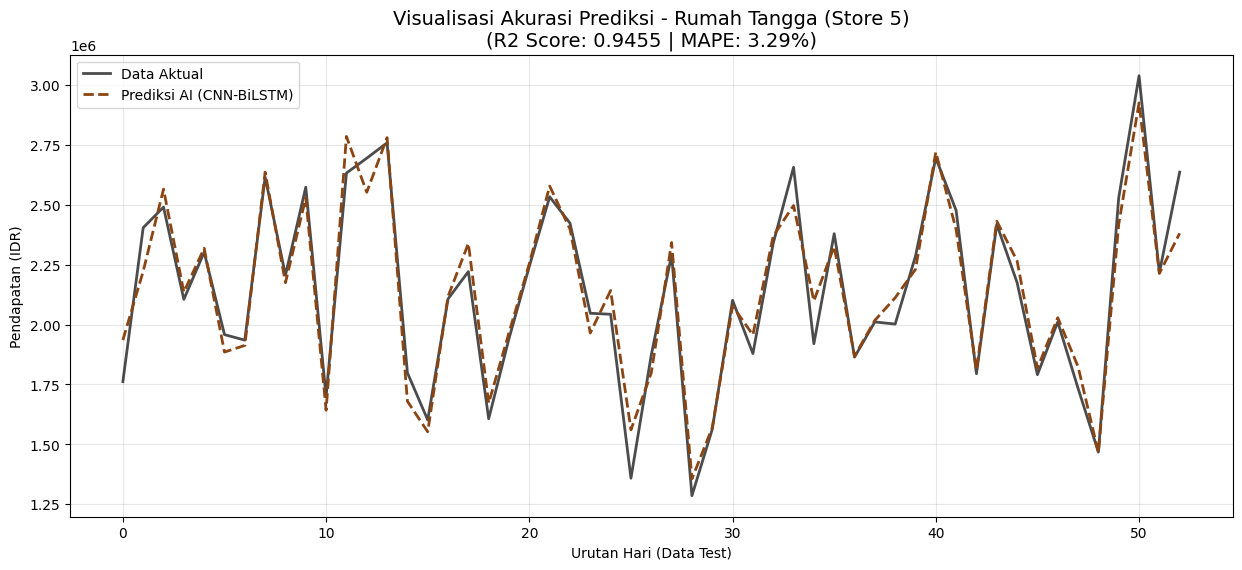

In [30]:
# --- VISUALISASI 1: PERBANDINGAN AKTUAL VS PREDIKSI ---
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual', color='black', linewidth=2, alpha=0.7)
plt.plot(y_pred, label='Prediksi AI (CNN-BiLSTM)', color='saddlebrown', linestyle='--', linewidth=2)
plt.title(f'Visualisasi Akurasi Prediksi - Rumah Tangga (Store 5)\n(R2 Score: {r2:.4f} | MAPE: {mape:.2f}%)', fontsize=14)
plt.xlabel('Urutan Hari (Data Test)')
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

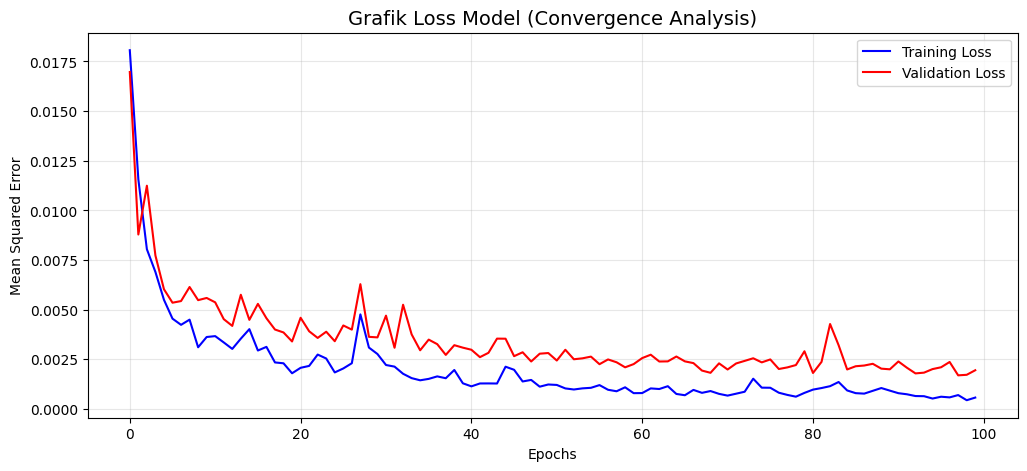

In [31]:
# --- VISUALISASI 2: LOSS CURVE (TRAINING VS VALIDATION) ---
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Grafik Loss Model (Convergence Analysis)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save Model

In [32]:
# Simpan Model & Scaler Rumah Tangga
# Path disesuaikan untuk Rumah Tangga (Store 5)
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/model_home_store_5.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Simpan Model (.keras)
best_model.save(model_path)

# Simpan Scaler (.pkl)
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/scaler_X_home.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/scaler_y_home.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/scaler_y_home.pkl']

# Kode Inference Dengan Analisis Bisnis

In [33]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/model_home_store_5.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/scaler_X_home.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/rumah_tangga/scaler_y_home.pkl')

In [34]:
def get_forecast_7_days_stabilized_home(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (untuk Rem/Stabilizer)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL HOME & DECOR TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Jangan biarkan melebihi 120% dari nilai maksimum historis
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Status berdasarkan statistik rata-rata industri home decor
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [35]:
# Jalankan Proyeksi Baru untuk Home Decor
forecast_results_stable_home = get_forecast_7_days_stabilized_home(best_model, time_series_home, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL HOME & DECOR TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 2,375,170 | NORMAL
Wednesday, 14 Jan: Rp 2,350,402 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 2,353,071 | NORMAL
Friday, 16 Jan: Rp 2,565,198 | RAMAI
Saturday, 17 Jan: Rp 2,470,039 | RAMAI


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 2,324,570 | NORMAL
Monday, 19 Jan: Rp 2,340,919 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


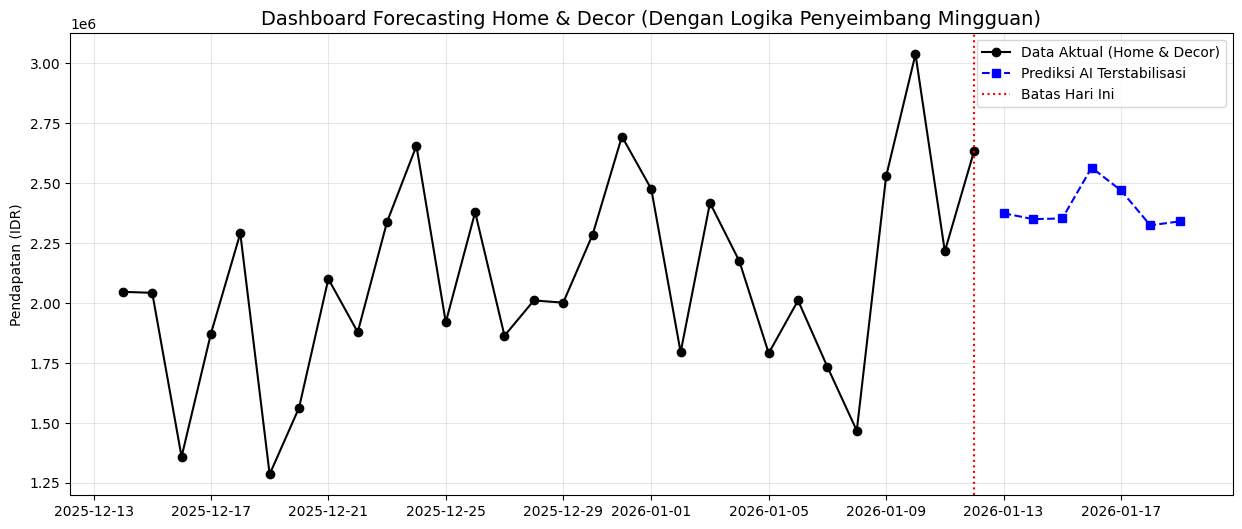

In [36]:
# Visualisasi
plt.figure(figsize=(15, 6))
hist_data_home = time_series_home.tail(30)

plt.plot(hist_data_home.index, hist_data_home['revenue_clean'],
         label='Data Aktual (Home & Decor)', color='black', marker='o')

plt.plot(forecast_results_stable_home.index, forecast_results_stable_home['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_home.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Forecasting Home & Decor (Dengan Logika Penyeimbang Mingguan)', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()